In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2017-10-05 09:29:34


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [4]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.peak_functions_c as cpf

from   invisible_cities.evm.ic_containers           import S12Params 
from   invisible_cities.evm.ic_containers          import CalibVectors
from   invisible_cities.evm.ic_containers          import DeconvParams
from   invisible_cities.evm.ic_containers          import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
from   invisible_cities.types.ic_types import Counters
import invisible_cities.icaro.mpl_functions as mpl
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.icaro.pmaps_mpl import plot_s2si_map

In [23]:
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf

In [6]:
import invisible_cities.evm.event_model as evm

In [7]:
from invisible_cities.evm.pmaps import S12
from invisible_cities.evm.pmaps import S1
from invisible_cities.evm.pmaps import S2
from invisible_cities.evm.pmaps import S2Si

In [8]:
from invisible_cities.core.exceptions        import SipmEmptyList
from invisible_cities.core.exceptions        import SipmNotFound
from invisible_cities.core.exceptions        import PeakNotFound

In [9]:
run_number = 4708
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [10]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [11]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,18,PMT1,1,-23.9414,65.7785,0.000788,0.000002,25.160,0.75,10.023
1,1,22,PMT3,1,-44.9951,-53.6231,0.000789,0.000002,26.459,0.78,11.374
2,2,19,PMT2,1,68.9365,-12.1554,0.000775,0.000002,27.709,0.75,10.283
3,3,23,PMT4,1,0.0000,185.0000,0.000778,0.000002,28.305,0.73,11.115
4,4,9,PMTC,1,-118.9160,141.7180,0.000789,0.000002,33.345,0.80,12.086
5,5,8,PMTB,1,-182.1890,32.1249,0.000781,0.000002,24.734,0.78,8.796
6,6,5,PMTA,1,-160.2150,-92.5000,0.000794,0.000002,28.420,0.76,10.432
7,7,4,PMT9,1,-63.2737,-173.8430,0.000773,0.000002,36.961,0.77,13.464
8,8,1,PMT8,1,63.2737,-173.8430,0.000788,0.000002,26.526,0.81,9.323
9,10,31,PMT6,1,182.1890,32.1249,0.000782,0.000002,23.456,0.79,8.347


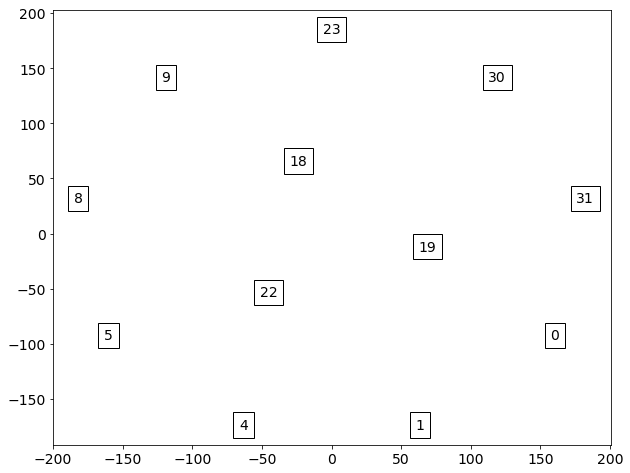

In [12]:
mpl.draw_pmt_map(run_number)

In [15]:
RWF_file = os.path.join('/Users/jjgomezcadenas/Projects/ICDATA', 'LSC',
                        'dst_waves.gdcsnext.003_4708.root.h5')
print('RWF file = {}'.format(RWF_file))

RWF file = /Users/jjgomezcadenas/Projects/ICDATA/LSC/dst_waves.gdcsnext.003_4708.root.h5


In [16]:
h5rwf = tb.open_file(RWF_file,'r')

In [17]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
NEVT, pmtrwf, sipmrwf, _ = tbl.get_rwf_vectors(h5rwf)
sp = tbl.get_sensor_params_from_vectors(pmtrwf, sipmrwf)
print(sp)

####################
SensorParams
####################
npmt: 12
pmtwl: 52000
nsipm: 1792
sipmwl: 1300



### Reconstruction Parameters

In [113]:
calib_vectors = CalibVectors(channel_id = DataPMT.ChannelID.values,
                             coeff_blr = abs(DataPMT.coeff_blr   .values),
                             coeff_c = abs(DataPMT.coeff_c   .values),
                             adc_to_pes = DataPMT.adc_to_pes.values,
                             adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                             pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist())


deconv_params = DeconvParams(n_baseline = 48000,
                              thr_trigger = 5)

s1par = S12Params(time = minmax(min    = 0 * units.mus,
                                max    = 645 * units.mus),
                                stride = 4,
                                length = minmax(min = 6, max = 20),  #150 ns -- 500 ns
                                rebin_stride  = 1)

s2par = S12Params(time = minmax(min    = 645 * units.mus,
                                max    = 1300 * units.mus),
                                stride = 40,
                                length = minmax(min = 80, max = 1e5),  # 4 mus --
                                rebin_stride  = 40)

thresholds = ThresholdParams(thr_s1=0.5 * units.pes,
                      thr_s2=1.0 * units.pes,
                      thr_MAU=3*units.adc,
                      thr_sipm=1.5*units.pes,
                      thr_SIPM=5*units.pes)



In [20]:
event = 0

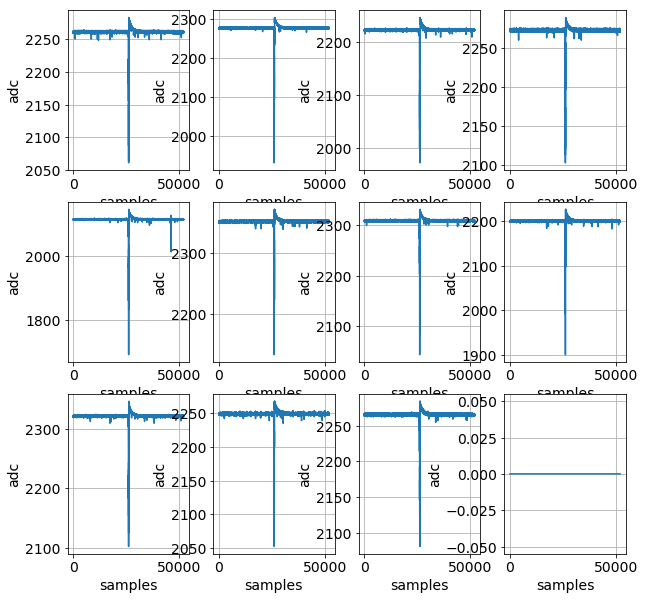

In [24]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))

#### Deconvolution

In [25]:
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)

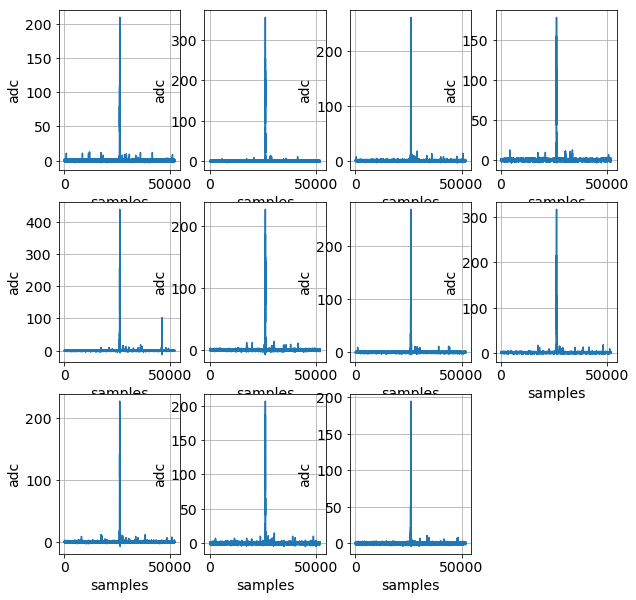

In [26]:
sf.plot_pmt_waveforms(CWF, zoom=False, window_size=1200, figsize=(10,10))

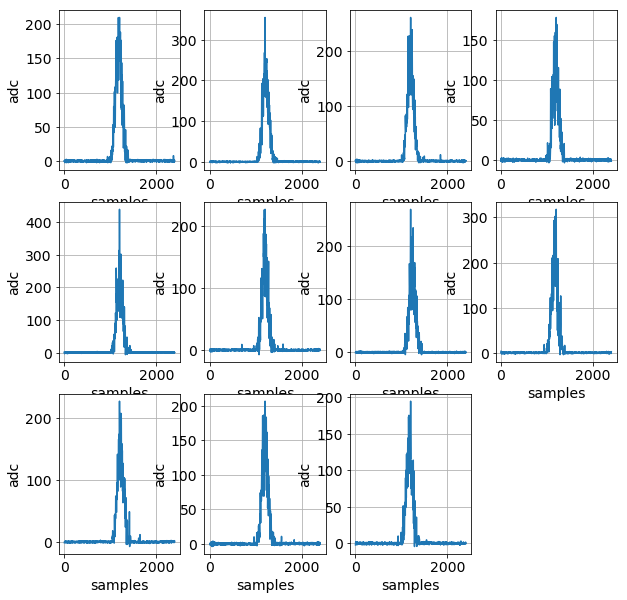

In [27]:
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(10,10))

#### csum

In [28]:
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)

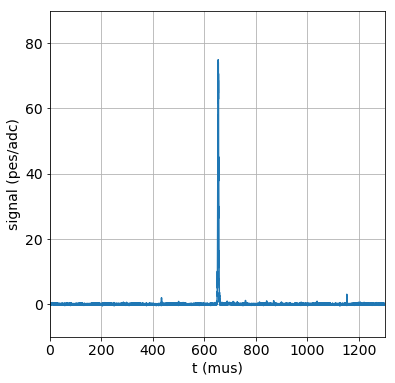

In [35]:
sf.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  90,
                        figsize=(6,6))

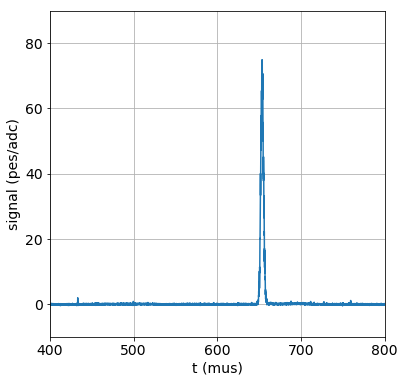

In [34]:
sf.plot_signal_vs_time_mus(csum,
                        t_min      = 400,
                        t_max      = 800,
                        signal_min =    -10,
                        signal_max =  90,
                        figsize=(6,6))

#### S1 and S2

In [36]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)

In [43]:
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())


In [38]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 6 width =      0.1 mus , energy =      9.2 pes
        height =      2.0 pes tmin-tmax = minmax(min=433.125, max=433.25) mus  

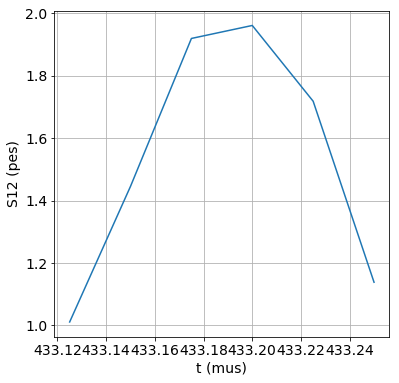

In [39]:
plot_s12(s1)

In [44]:
s2

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 10 width =      8.6 mus , energy =  11079.4 pes
        height =   2702.7 pes tmin-tmax = minmax(min=650.5, max=659.075) mus  

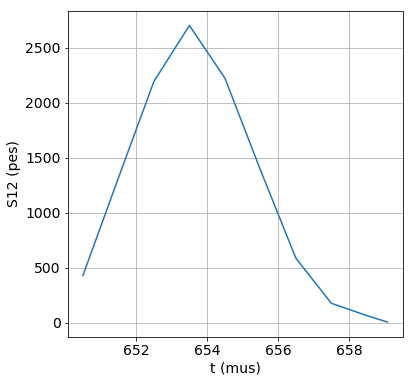

In [45]:
plot_s12(s2)

#### S2Si

In [46]:
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)

In [47]:
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)

In [48]:
s2si

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 10 width =      8.6 mus , energy =  11079.4 pes
        height =   2702.7 pes tmin-tmax = minmax(min=650.5, max=659.075) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (597, 1030, 1035, 1036, 1037, 1042, 1043, 1044, 1045, 1046, 1047, 1049, 1050, 1051, 1052, 1053, 1054, 1058, 1059, 1060, 1061, 1067, 1068, 1069, 1326)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 597
    sipm waveform (zs) = Peak(samples = 2 width =      1.0 mus , energy =      6.2 pes
        height =      4.6 pes tmin-tmax = minmax(min=651.5, max=652.5) mus 
peak number = 0: sipm number = 1030
    sipm waveform (zs) = Peak(samples = 3 width =      2.0 mus , energy =      6.8 pes
        height =      3.1 pes tmin-tmax = minmax(min=651.5, max=653.5) mus 
peak number = 0: sipm number =

In [50]:
s2si.number_of_peaks

1

In [51]:
s2si.sipms_in_peak(0)

(597,
 1030,
 1035,
 1036,
 1037,
 1042,
 1043,
 1044,
 1045,
 1046,
 1047,
 1049,
 1050,
 1051,
 1052,
 1053,
 1054,
 1058,
 1059,
 1060,
 1061,
 1067,
 1068,
 1069,
 1326)

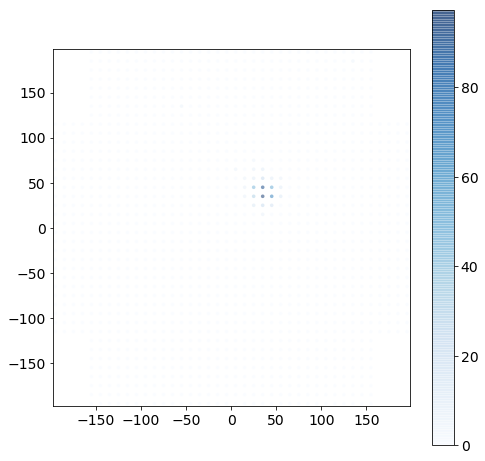

In [53]:
plot_s2si_map(s2si, run_number=run_number)

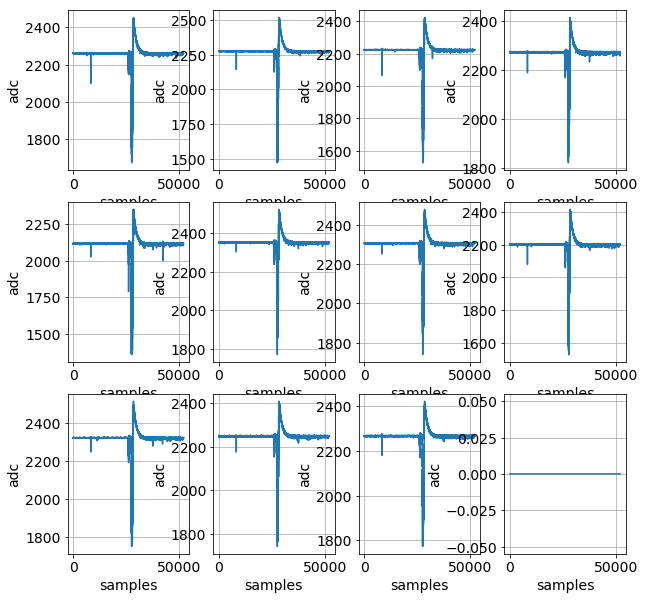

In [114]:
event = 123
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))

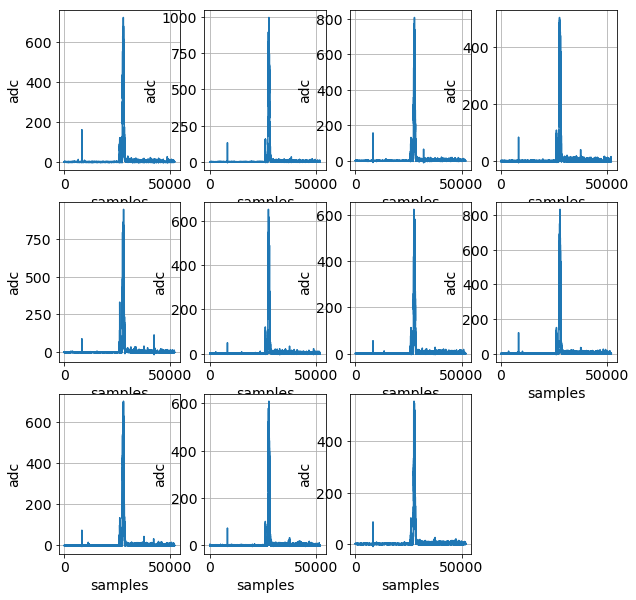

In [115]:
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)


sf.plot_pmt_waveforms(CWF, zoom=False, window_size=1200, figsize=(10,10))

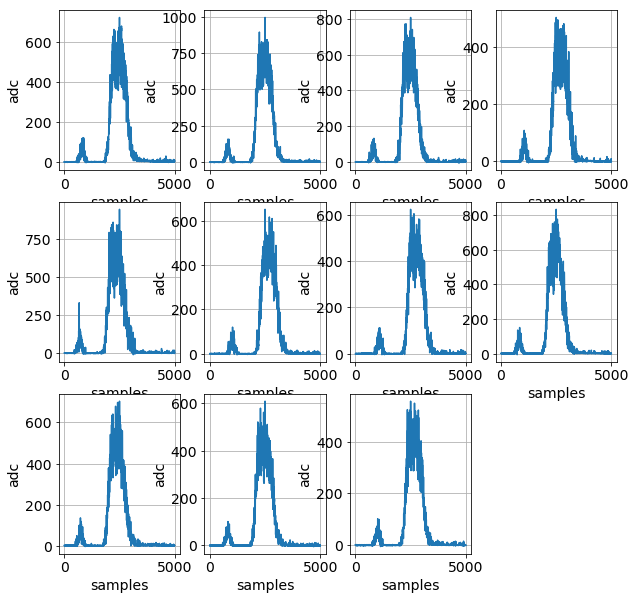

In [116]:
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=2500, figsize=(10,10))

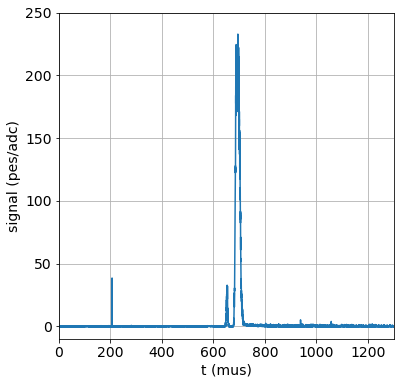

In [117]:
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)

sf.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  250,
                        figsize=(6,6))

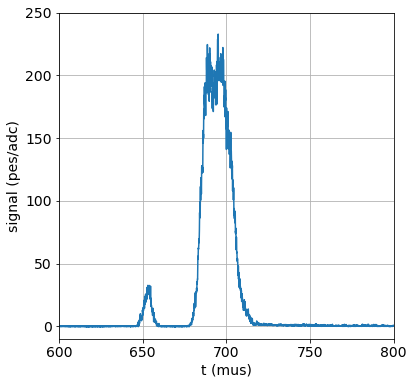

In [118]:
sf.plot_signal_vs_time_mus(csum,
                        t_min      = 600,
                        t_max      = 800,
                        signal_min =    -10,
                        signal_max =  250,
                        figsize=(6,6))

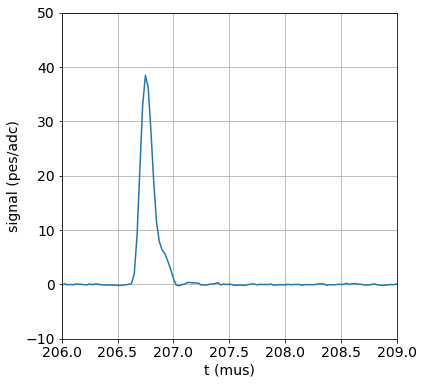

In [119]:
sf.plot_signal_vs_time_mus(csum,
                        t_min      = 206,
                        t_max      = 209,
                        signal_min =    -10,
                        signal_max =  50,
                        figsize=(6,6))

In [125]:
s1par = S12Params(time = minmax(min    = 0 * units.mus,
                                max    = 640 * units.mus),
                                stride = 4,
                                length = minmax(min = 6, max = 30),  #150 ns -- 500 ns
                                rebin_stride  = 1)



In [126]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())

In [127]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 23 width =      0.6 mus , energy =    226.7 pes
        height =     38.5 pes tmin-tmax = minmax(min=206.65, max=207.20000000000002) mus  

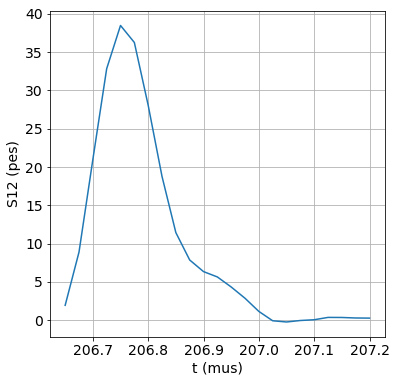

In [128]:
plot_s12(s1)

### This appears to be a decent S1 with a longish tail, perhaps we need to be a bit more tolerant with S1 width

In [136]:
s2par = S12Params(time = minmax(min    = 649 * units.mus,
                                max    = 1300 * units.mus),
                                stride = 40,
                                length = minmax(min = 200, max = 1e5),  # 4 mus --
                                rebin_stride  = 40)



In [137]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())

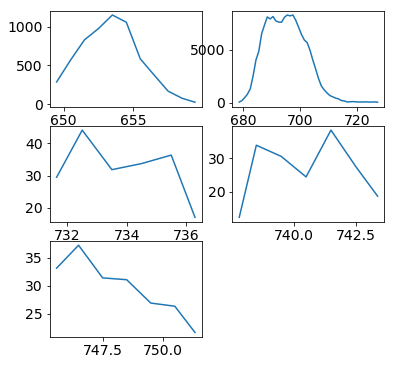

In [138]:
plot_s12(s2)

In [140]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=2*units.pes)
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())

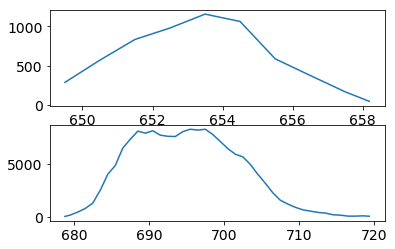

In [141]:
plot_s12(s2)

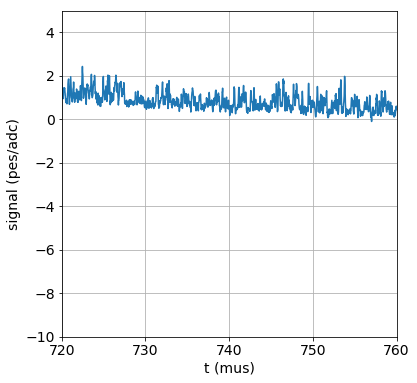

In [135]:
sf.plot_signal_vs_time_mus(csum,
                        t_min      = 720,
                        t_max      = 760,
                        signal_min =    -10,
                        signal_max =  5,
                        figsize=(6,6))

#### This is clearly spurous stuff, associated with rebinning

In [104]:
thresholds = ThresholdParams(thr_s1=0.5 * units.pes,
                      thr_s2=2.0 * units.pes,
                      thr_MAU=3*units.adc,
                      thr_sipm=1.5*units.pes,
                      thr_SIPM=5*units.pes)



In [105]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())

In [106]:
s2

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 10 width =      8.7 mus , energy =   6045.7 pes
        height =   1152.7 pes tmin-tmax = minmax(min=649.5, max=658.1875) mus  
peak number = 1: Peak(samples = 42 width =     40.6 mus , energy = 161346.6 pes
        height =   8278.4 pes tmin-tmax = minmax(min=678.7875, max=719.35) mus  

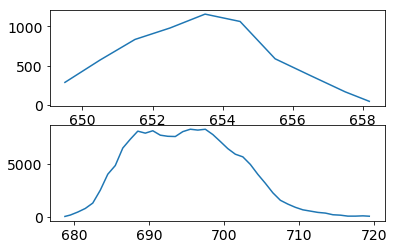

In [107]:
plot_s12(s2)

#### It goes away by rising slightly the threshold for S2s. 

In [108]:
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)

In [110]:
print(s2si.number_of_peaks)

2


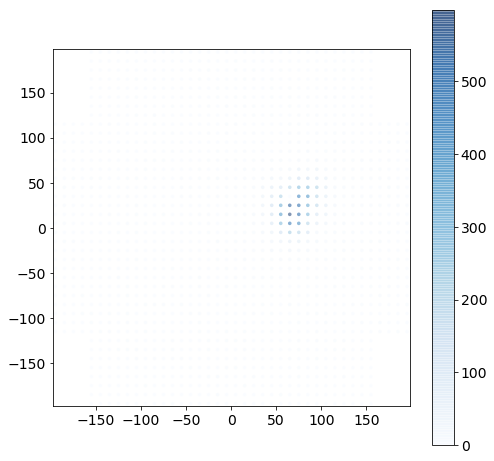

In [111]:
plot_s2si_map(s2si, run_number=run_number)

In [ ]:

plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 6 width =      0.1 mus , energy =      8.1 pes
        height =      1.8 pes tmin-tmax = minmax(min=100.075, max=100.2) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 10 width =      8.7 mus , energy =   3441.2 pes
        height =    809.2 pes tmin-tmax = minmax(min=383.77500000000003, max=392.45) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 10 width =      8.7 mus , energy =   3441.2 pes
        height =    809.2 pes tmin-tmax = minmax(min=383.77500000000003, max=392.45) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (776, 777, 784, 785, 792, 855)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 776
    sipm waveform (zs) = Peak(samples = 7 width =      6.0 mus , energy =     54.9 pes
        height =     24.0 pes t

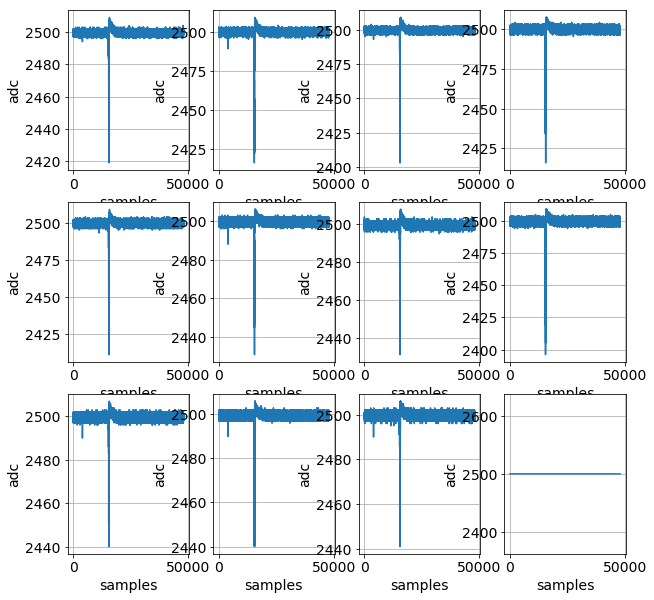

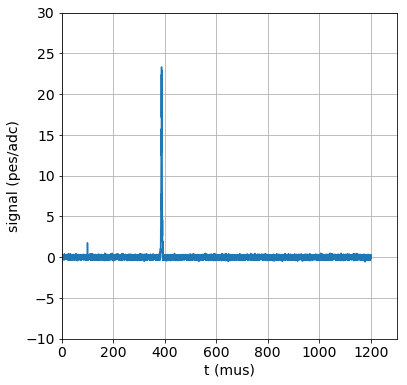

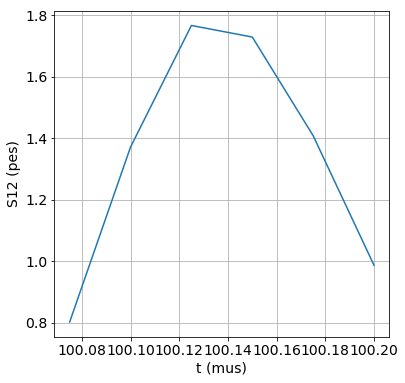

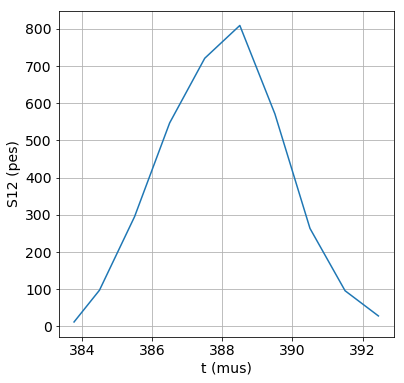

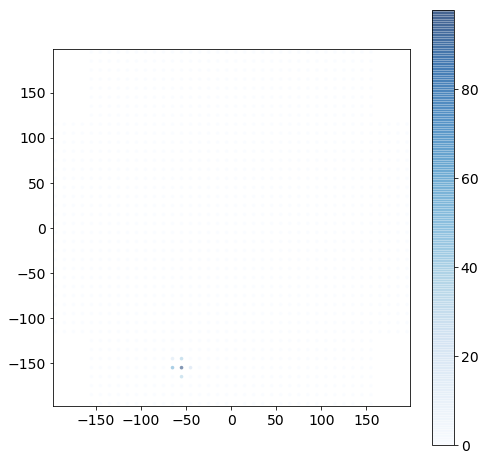

In [38]:
event = 2
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 0)

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      6.2 mus , energy =   4327.0 pes
        height =   1251.7 pes tmin-tmax = minmax(min=232.9625, max=239.1875) mus  



ZeroDivisionError: float modulo

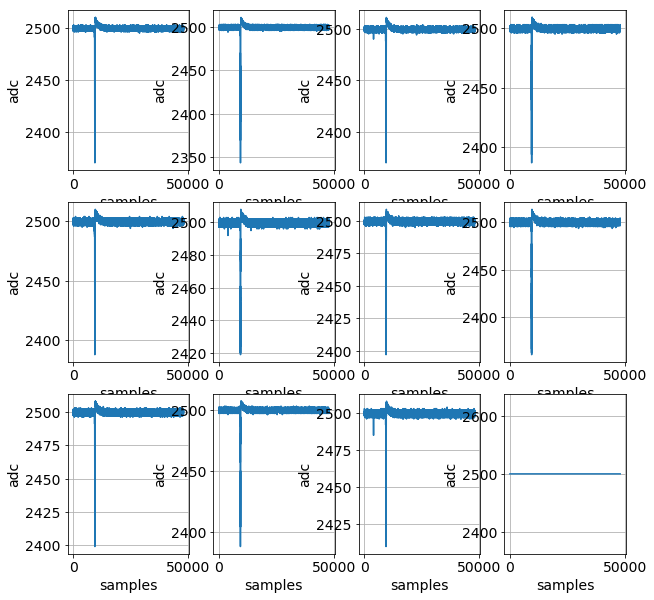

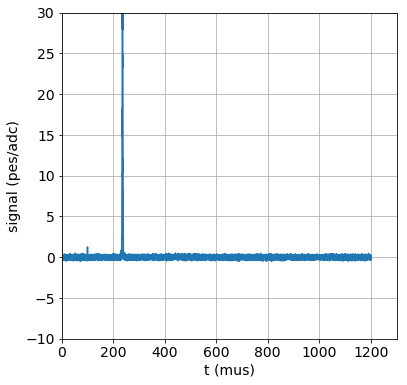

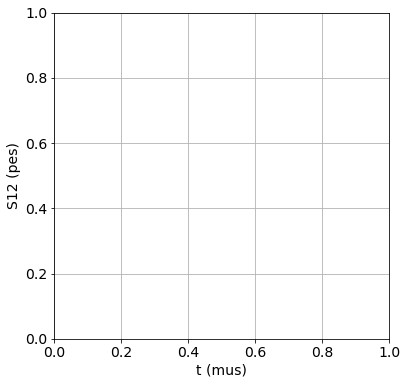

In [39]:
event = 3
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      0.2 mus , energy =      7.6 pes
        height =      1.2 pes tmin-tmax = minmax(min=100.10000000000001, max=100.275) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      6.4 mus , energy =   4322.4 pes
        height =   1212.3 pes tmin-tmax = minmax(min=257.75, max=264.1625) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 8 width =      6.4 mus , energy =   4322.4 pes
        height =   1212.3 pes tmin-tmax = minmax(min=257.75, max=264.1625) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (1436, 1437, 1438, 1444, 1445)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 1436
    sipm waveform (zs) = Peak(samples = 6 width =      4.8 mus , energy =     84.4 pes
        height =     29.9 pes tmin-tmax

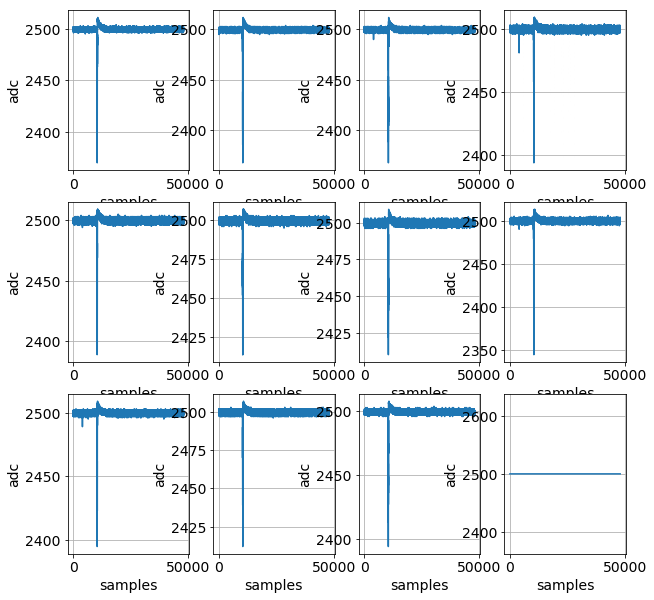

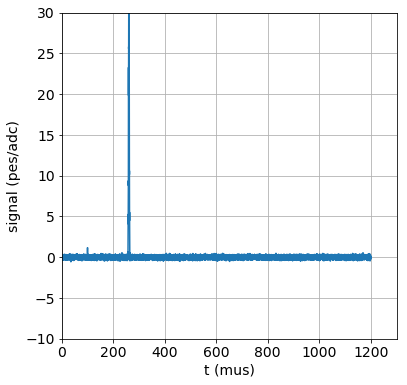

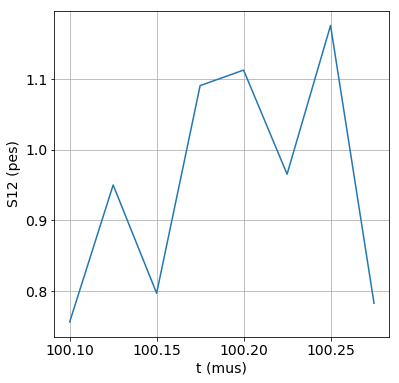

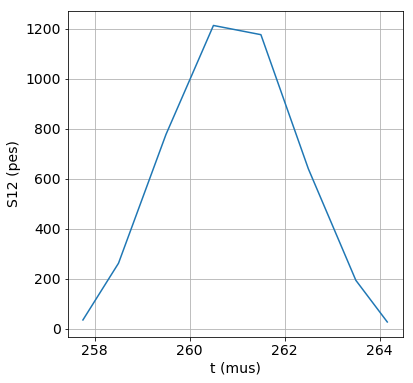

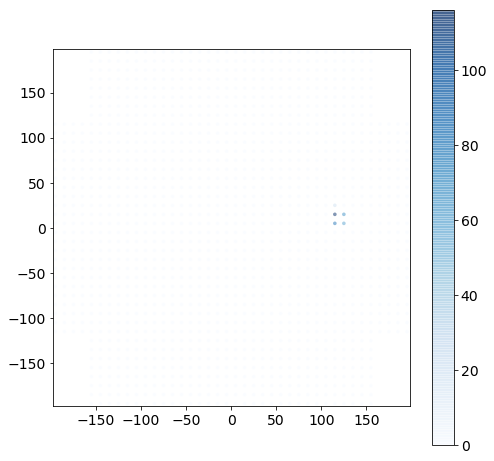

In [40]:
event = 4
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 7 width =      0.1 mus , energy =     14.9 pes
        height =      2.8 pes tmin-tmax = minmax(min=100.075, max=100.22500000000001) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      9.4 mus , energy =   3372.0 pes
        height =    689.1 pes tmin-tmax = minmax(min=496.96250000000003, max=506.325) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      9.4 mus , energy =   3372.0 pes
        height =    689.1 pes tmin-tmax = minmax(min=496.96250000000003, max=506.325) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (1493, 1494, 1501, 1502, 1503, 1509, 1510, 1511)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 1493
    sipm waveform (zs) = Peak(samples = 5 width =      5.0 mus , energy =     16.6 p

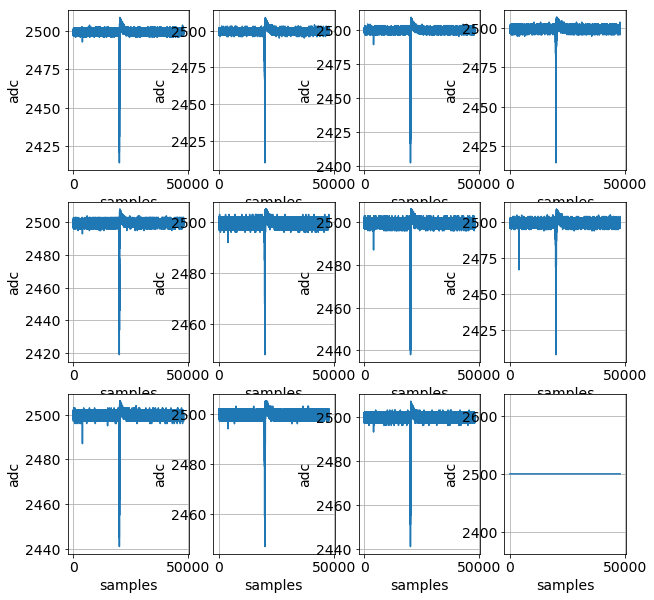

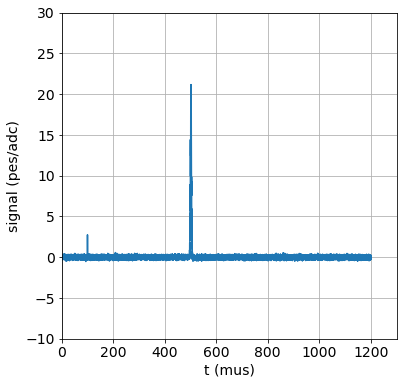

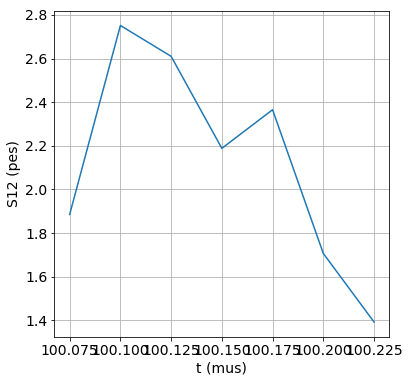

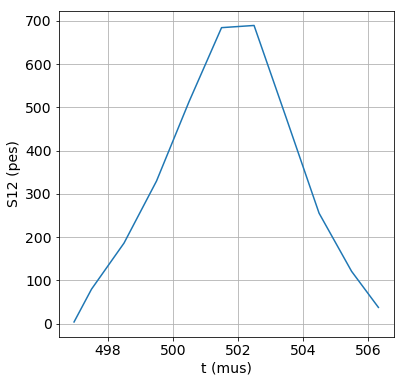

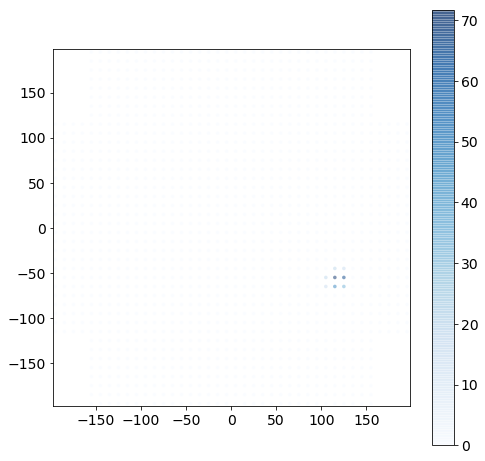

In [41]:
event = 5
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)